In [1]:
from graph_class import *
from nltk_class import *
from text_mining import *

In [2]:
with open('twitter.json', 'r') as file:
    tweet = pd.DataFrame(json.load(file))

In [3]:
nlp = NltkTextProcessing()
tweet_df = nlp.process_df_text_column(tweet, save=False)
tweet_df = nlp.process_df_hash_column(tweet_df)
unique_df = nlp.keep_unique(tweet_df)

In [4]:
' '.join(unique_df.iloc[0,2])

'oltre milioni ebrei militari rom omosessuali dissidenti politici rivoltando tomba greenpass qrcode lasciapassare marchioverde vaccino dittaturasanitaria'

In [5]:
print(f"Tweets including retweets: {len(tweet_df)}. Excluded: {len(unique_df)}")

Tweets including retweets: 39273. Excluded: 8555


In [ ]:
freq_distrib_tweet = nlp.frequency_dist(tweet_df, obj ='tweet')
graph_tweet = NetworkPlot.filter_pairwise_words(NetworkPlot.graph_filtered_dist(unique_df, freq_distrib_tweet, 900), 40)
NetworkPlot(graph=graph_tweet, frequency_dist=freq_distrib_tweet, label_thresold=400, color_thresold=900).plot()

In [ ]:
freq_distrib_hash = nlp.frequency_dist(tweet_df, obj ='hash')
graph_hash = NetworkPlot.graph_filtered_dist(df=unique_df, distrib=freq_distrib_hash, thresold=300, obj='hash')
NetworkPlot(graph=graph_hash, frequency_dist=freq_distrib_hash, label_thresold=50, color_thresold=100).plot()

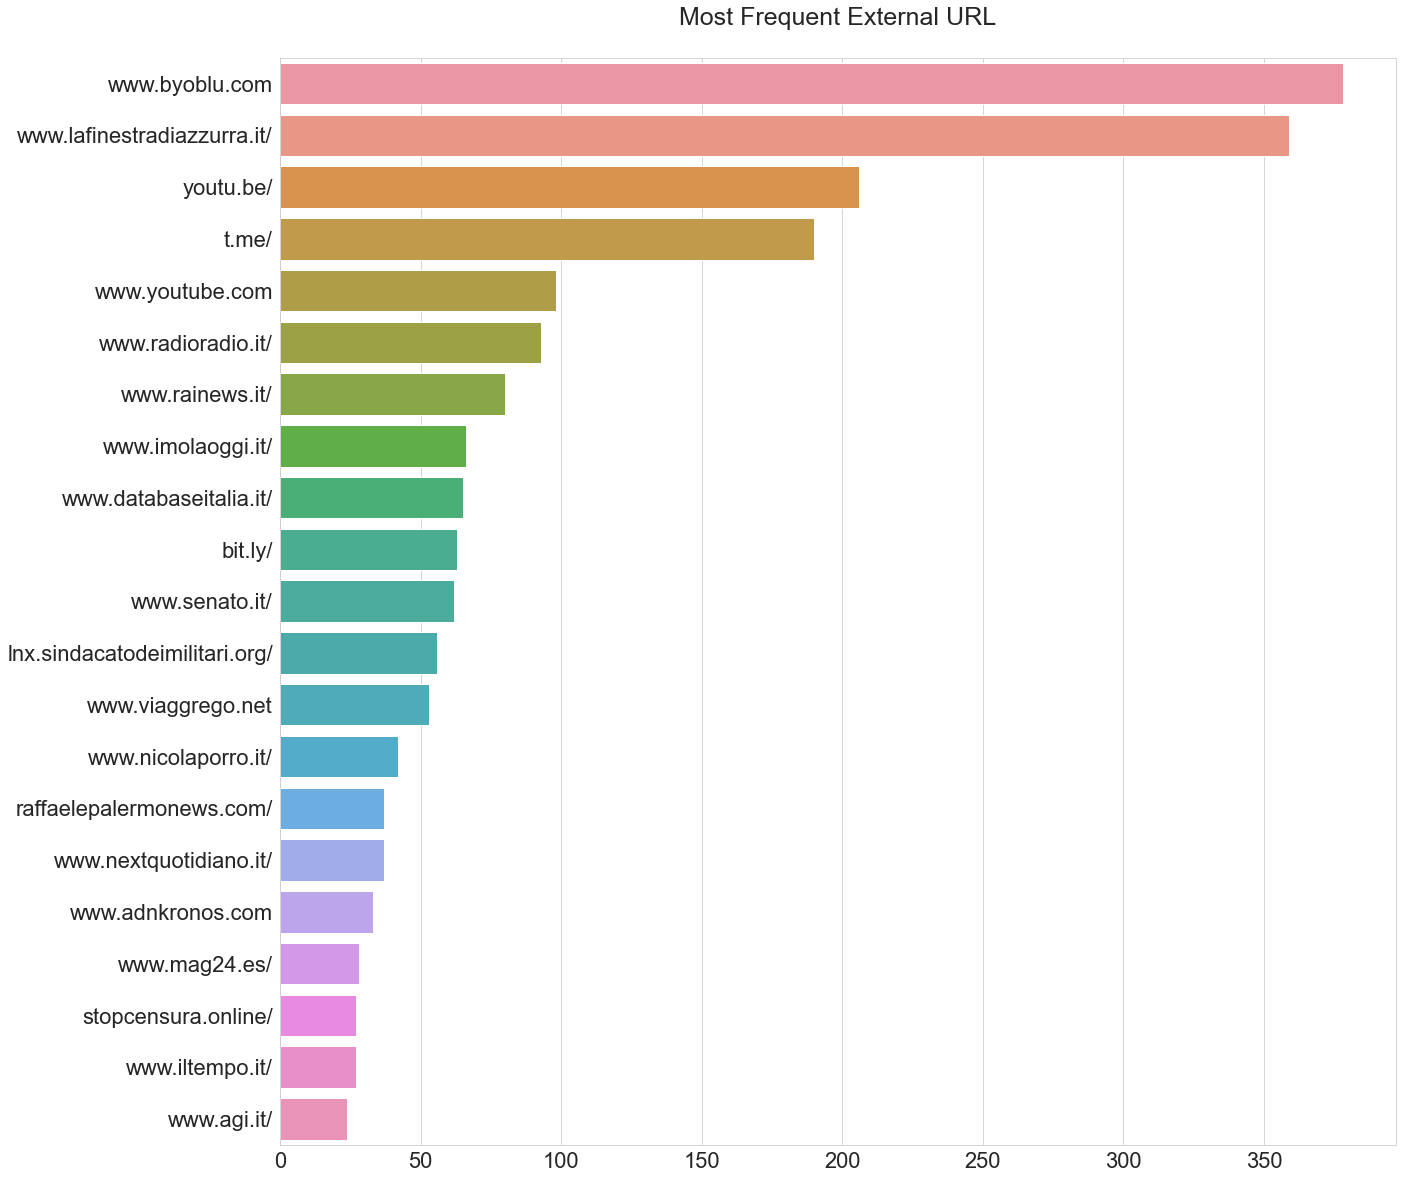

In [13]:
sns.set_style('white')
update_parameter()
count_barplot(nlp.extract_external_url(tweet_df), 20)

In [14]:
mining = TextMining()
text_to_vectorize = nlp.prepare_text_to_vectorize(unique_df, afil=True) # tweet_df
vectorized_text = mining.vectorized_text(text_to_vectorize)
print(f'Shape of the Sparse matrix: {vectorized_text.shape}')

Shape of the Sparse matrix: (8555, 19401)


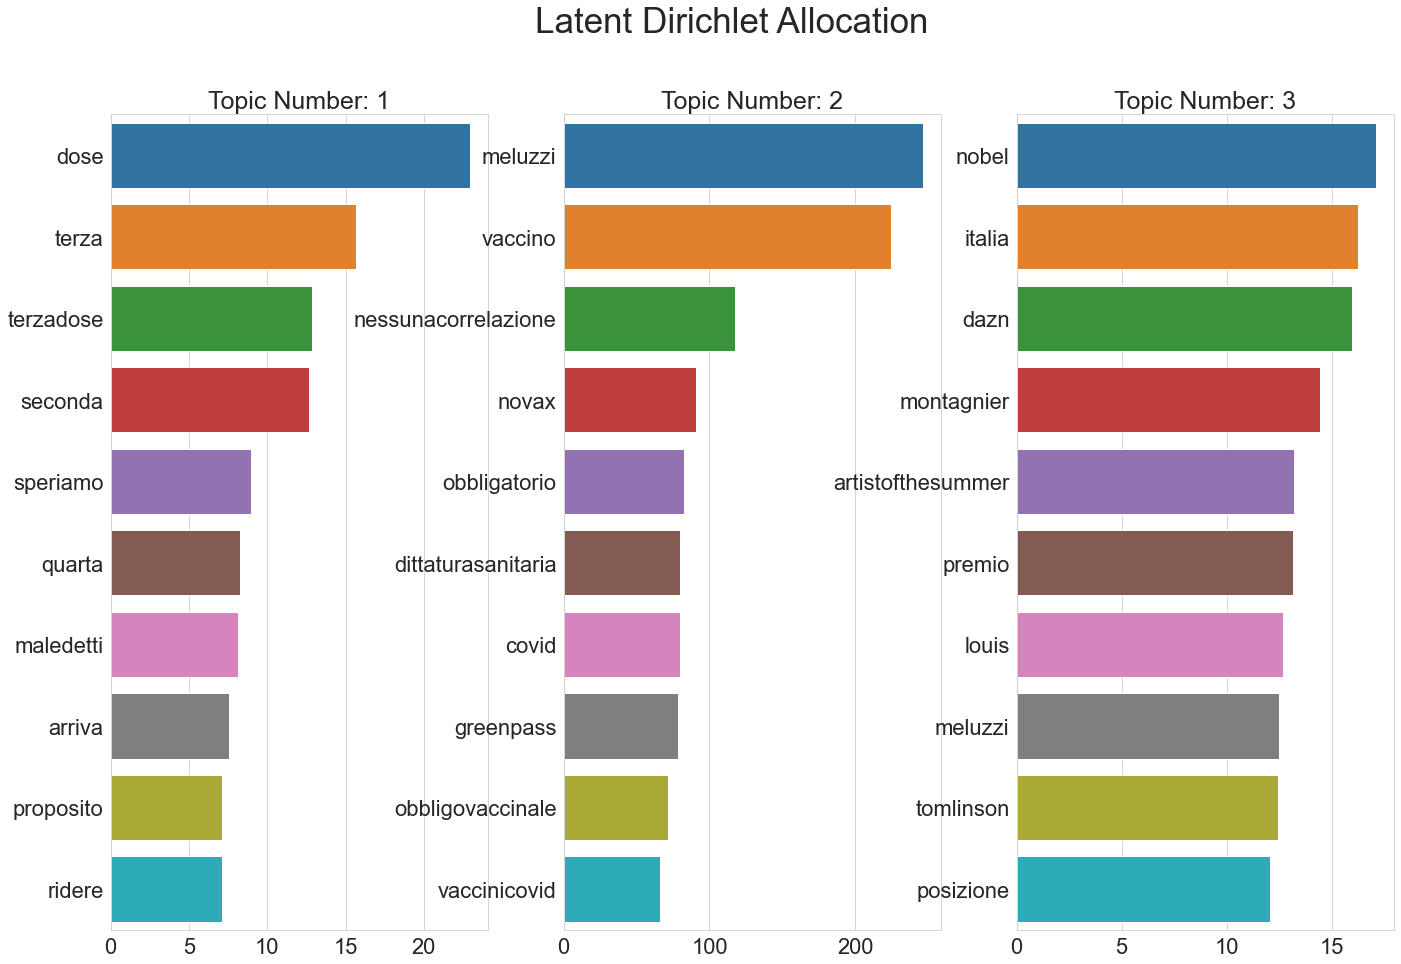

In [15]:
lda_model, feature_names = mining.lda_topic_modeling(vectorized_text, 3)
mining.plot_lda_topic(lda_model, 10)

Explained variance of the SVD step: 0.2559567130149369%


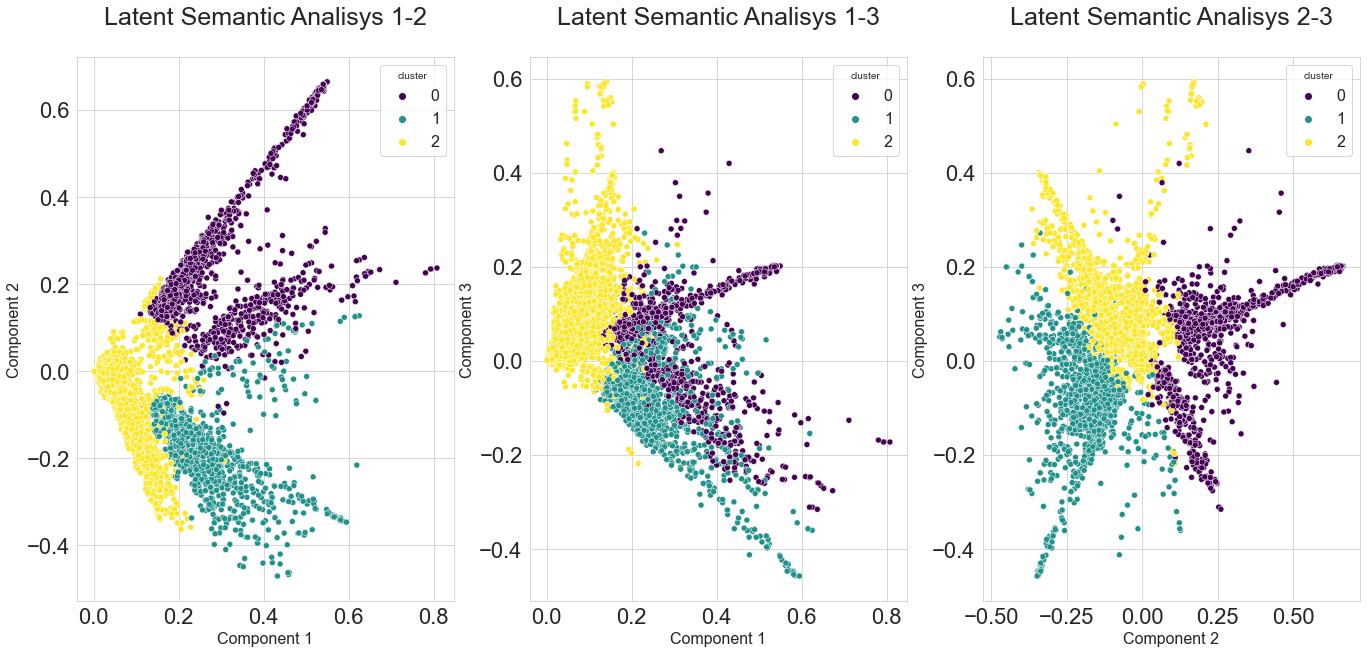

In [16]:
n_components = 300
svd_result = mining.latent_semantic_analysis(vectorized_text, n_components)
kmeans = mining.clustering_kmeans(svd_result, 3)
mining.plot_lsa(svd_result, kmeans, n_components)

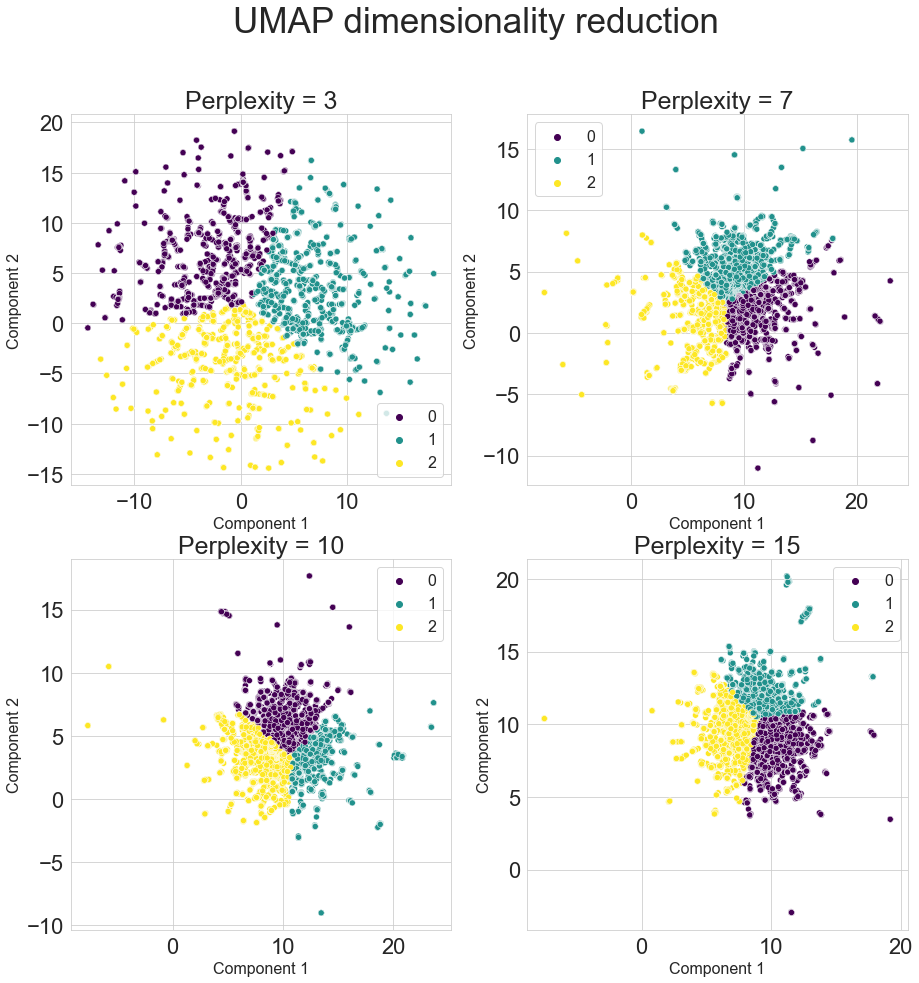

In [17]:
neighbours = [3,7,10,15]
umap_reduced = [mining.umaps(vectorized_text, k=i) for i in neighbours] #svd_result or vectorized_text?
mining.plot_umaps(umap_reduced, n_cluster=3, k=neighbours)

# HASHTAGS

In [9]:
mining = TextMining()
hash_to_vectorize = nlp.prepare_text_to_vectorize(unique_df, afil=True) # tweet_df
vectorized_hash = mining.vectorized_text(hash_to_vectorize)
print(f'Shape of the Sparse matrix: {vectorized_hash.shape}')

Shape of the Sparse matrix: (8555, 19401)


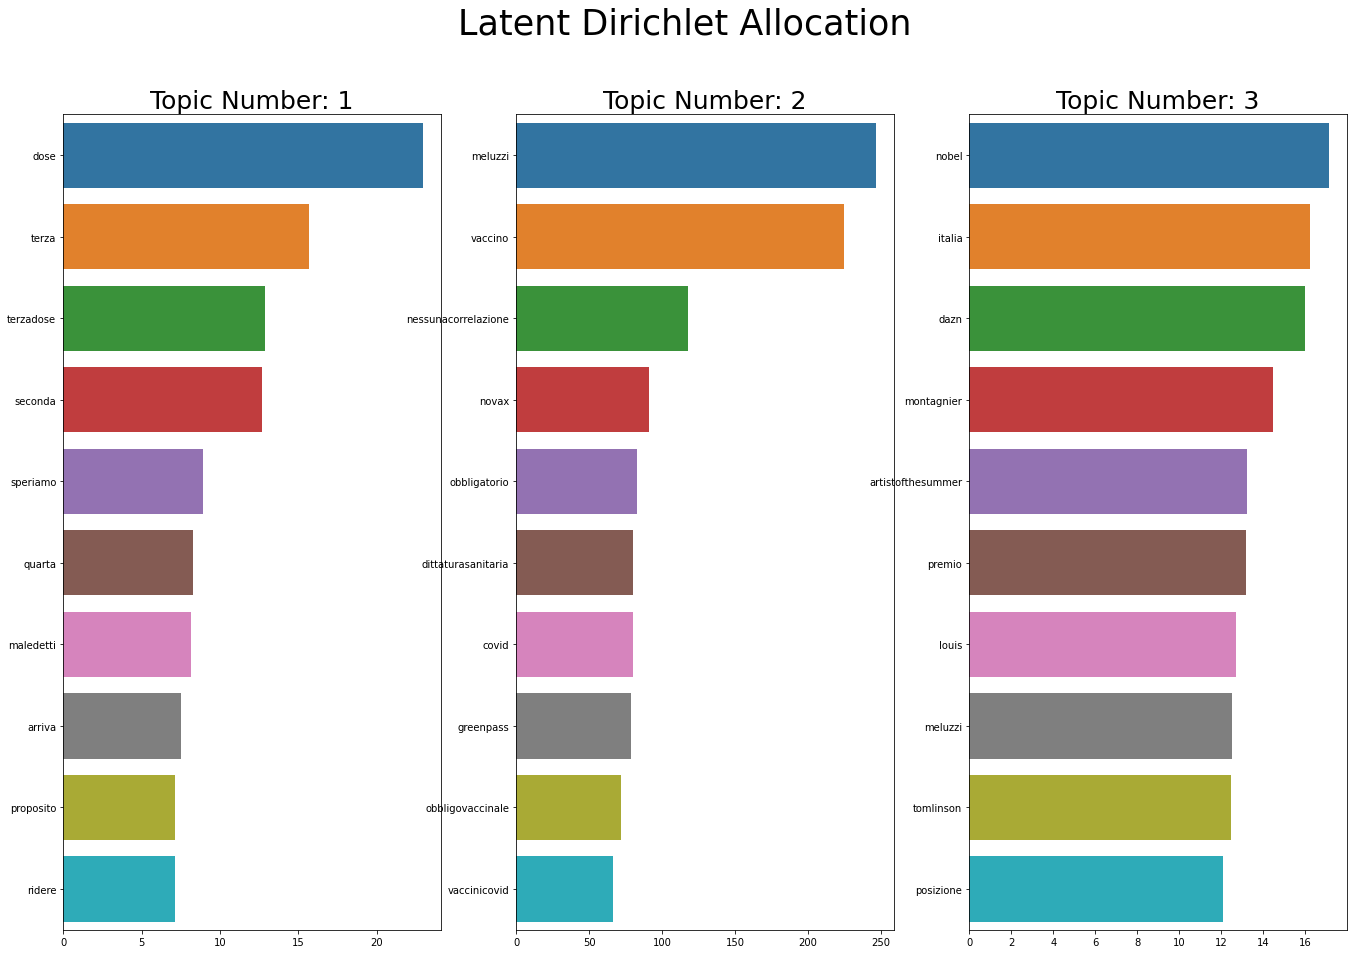

In [10]:
lda_model_hash, feature_names_hash = mining.lda_topic_modeling(vectorized_hash, 3)
mining.plot_lda_topic(lda_model_hash, 10)

Explained variance of the SVD step: 0.25596786490510043%


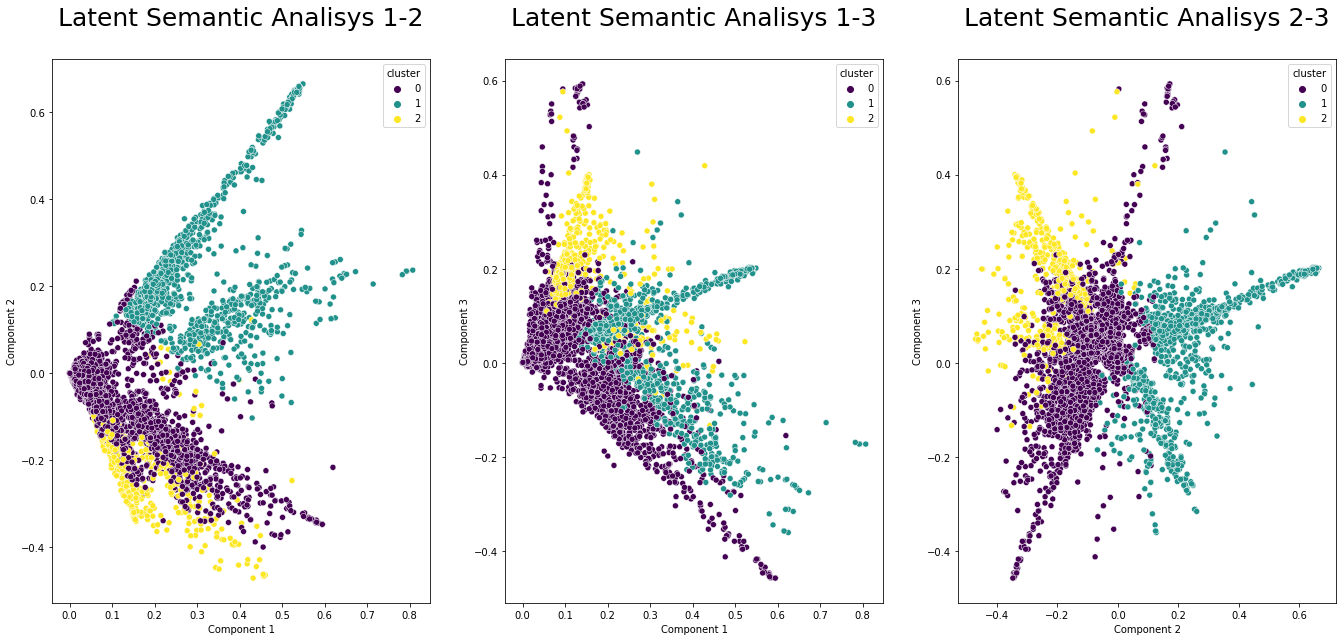

In [11]:
n_components = 300
svd_result_hash = mining.latent_semantic_analysis(vectorized_hash, n_components)
kmeans = mining.clustering_kmeans(svd_result_hash, 3)
mining.plot_lsa(svd_result_hash, kmeans, n_components)

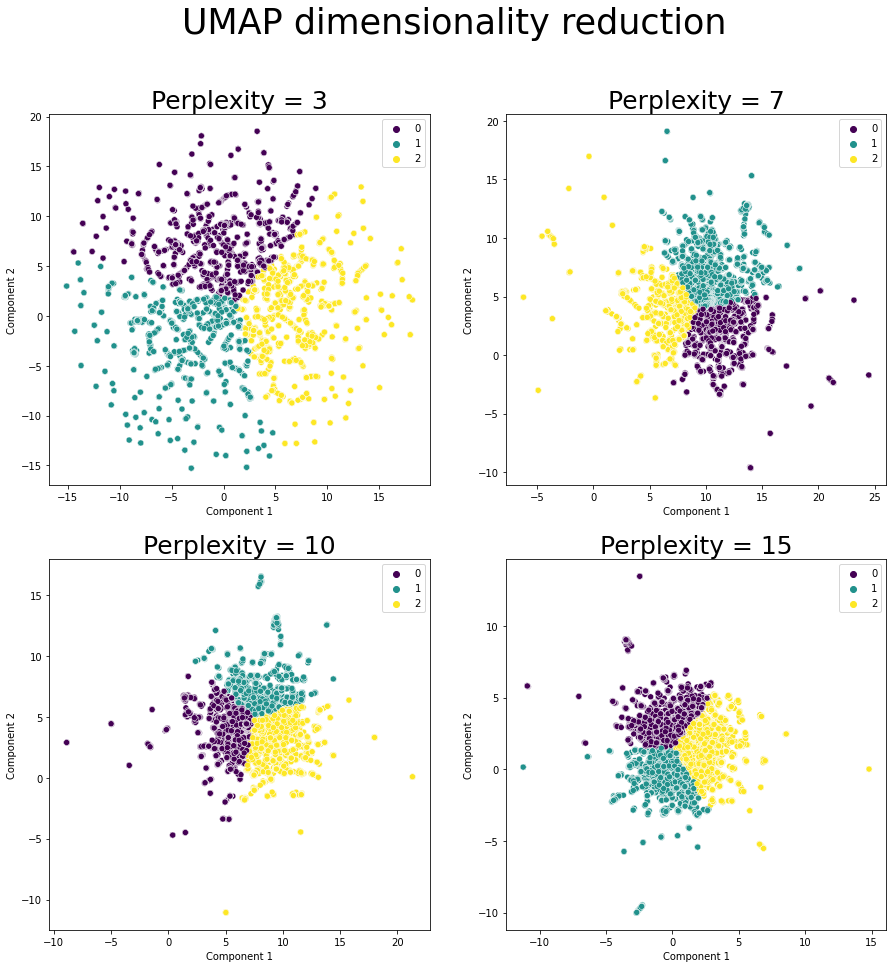

In [12]:
neighbours = [3,7,10,15]
umap_reduced_hash = [mining.umaps(vectorized_hash, k=i) for i in neighbours]
mining.plot_umaps(umap_reduced_hash, n_cluster=3, k=neighbours)